In [1]:
# Step 1: Install required packages
# pip install requests networkx matplotlib pandas

import requests
import time
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import numpy as np

Go to https://openalex.org/ and search author and paper. Then use ChatGPT to generat OpenAlex ID in python list.

In [2]:


# Step 2: List of OpenAlex work IDs (replace or extend as needed)
work_ids = [
    "W3036371598", "W3163131652", "W3095430612", "W4244166529", "W3214361718",
    "W4311307047", "W4296807072", "W4390500579", "W4407020722", "W2036321243",
    "W2116173775", "W2748111845", "W2612217087", "W3087697729", "W2763288334",
    "W3162853653", "W2941393885", "W2994778556", "W2972541534", "W4224249440",
    "W4313557856", "W4313830595", "W4407383764", "W2005578366", "W3186815057",
    "W3215292451", "W3184852358", "W4283699567", "W4376866784", "W4390660975",
    "W4402021167", "W2092205091", "W4306155241", "W4383535022", "W4379742489",
    "W1541096553", "W1983177630", "W3024455343", "W3092108146", "W4390631677",
    "W4409986323", "W2150282307", "W2803704156", "W3112392537", "W4353062192",
    "W4392507531", "W2966567262", "W3204417766", "W3213764588", "W3209891311",
    "W4390151054", "W4220927418", "W4392665413", "W2118220140", "W1965357442",
    "W2948418818", "W3129091481", "W4200416146", "W2943833592", "W4296998009",
    "W4382199322", "W4392593032", "W4393258275", "W4402321436", "W4405687361",
    "W2991628190", "W3127811986", "W2800237939", "W4244899237", "W3175349549",
    "W4200132698", "W4225312045", "W4281740856", "W4295066467", "W2918082105",
    "W3164841672", "W4200278267", "W2916386592", "W3110842356", "W4311304959",
    "W4390914994", "W4391845889", "W4396936577", "W4399672391", "W4400127512",
    "W4400127753", "W4405045253", "W2945829333", "W4377379160", "W4383217449",
    "W4388913730", "W4393595241", "W3169382593", "W4207005188", "W4285134940",
    "W3138515427", "W3174146823", "W4220892319", "W3127512909", "W2977378442",
    "W4377427392", "W4393625993", "W2254860741", "W3012157327", "W3121192550",
    "W4234785173", "W4241646549", "W4248059016", "W4234188306", "W4240023772",
    "W4241955097"
]


# Step 3: Collect author-institution data and co-author relationships
author_affiliation = {}
coauthorships = []

for work_id in work_ids:
    url = f"https://api.openalex.org/works/{work_id}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        authors = data.get("authorships", [])
        names = []
        for a in authors:
            name = a.get("author", {}).get("display_name", None)
            insts = a.get("institutions", [])
            if name:
                affil = insts[0]["display_name"] if insts else "Unknown"
                author_affiliation[name] = affil
                names.append(name)
        # Add coauthor edges
        for i in range(len(names)):
            for j in range(i + 1, len(names)):
                coauthorships.append((names[i], names[j]))
    except Exception as e:
        print(f"Error with {work_id}: {e}")
    time.sleep(1)  # polite delay




In [3]:
# Step 4: Build collaboration graph
G = nx.Graph()
G.add_edges_from(coauthorships)

# Step 5: Assign colors by institution
inst_color_map = {}
color_palette = plt.cm.get_cmap("tab20", 20)
node_colors = []

for node in G.nodes:
    inst = author_affiliation.get(node, "Unknown")
    if inst not in inst_color_map:
        inst_color_map[inst] = len(inst_color_map) % 20
    node_colors.append(color_palette(inst_color_map[inst]))
    
    # Extract all unique institutions from author affiliations
unique_institutions = set()
for author, affiliation in author_affiliation.items():
    # Handle both list and string formats of affiliation
    if isinstance(affiliation, list):
        if affiliation:  # Check if the list is not empty
            unique_institutions.add(affiliation[0])
    elif affiliation:  # Handle string format
        unique_institutions.add(affiliation)

# Map each institution to a color index (0-9), for use with matplotlib's tab10
institution_colors = {
    inst: i % 10 for i, inst in enumerate(sorted(unique_institutions))
}


/tmp/ipykernel_823975/2019200123.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap("tab20", 20)


/tmp/ipykernel_823975/1472217969.py:99: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(scatterpoints=1, loc='upper right', fontsize=10, title="Institutions")


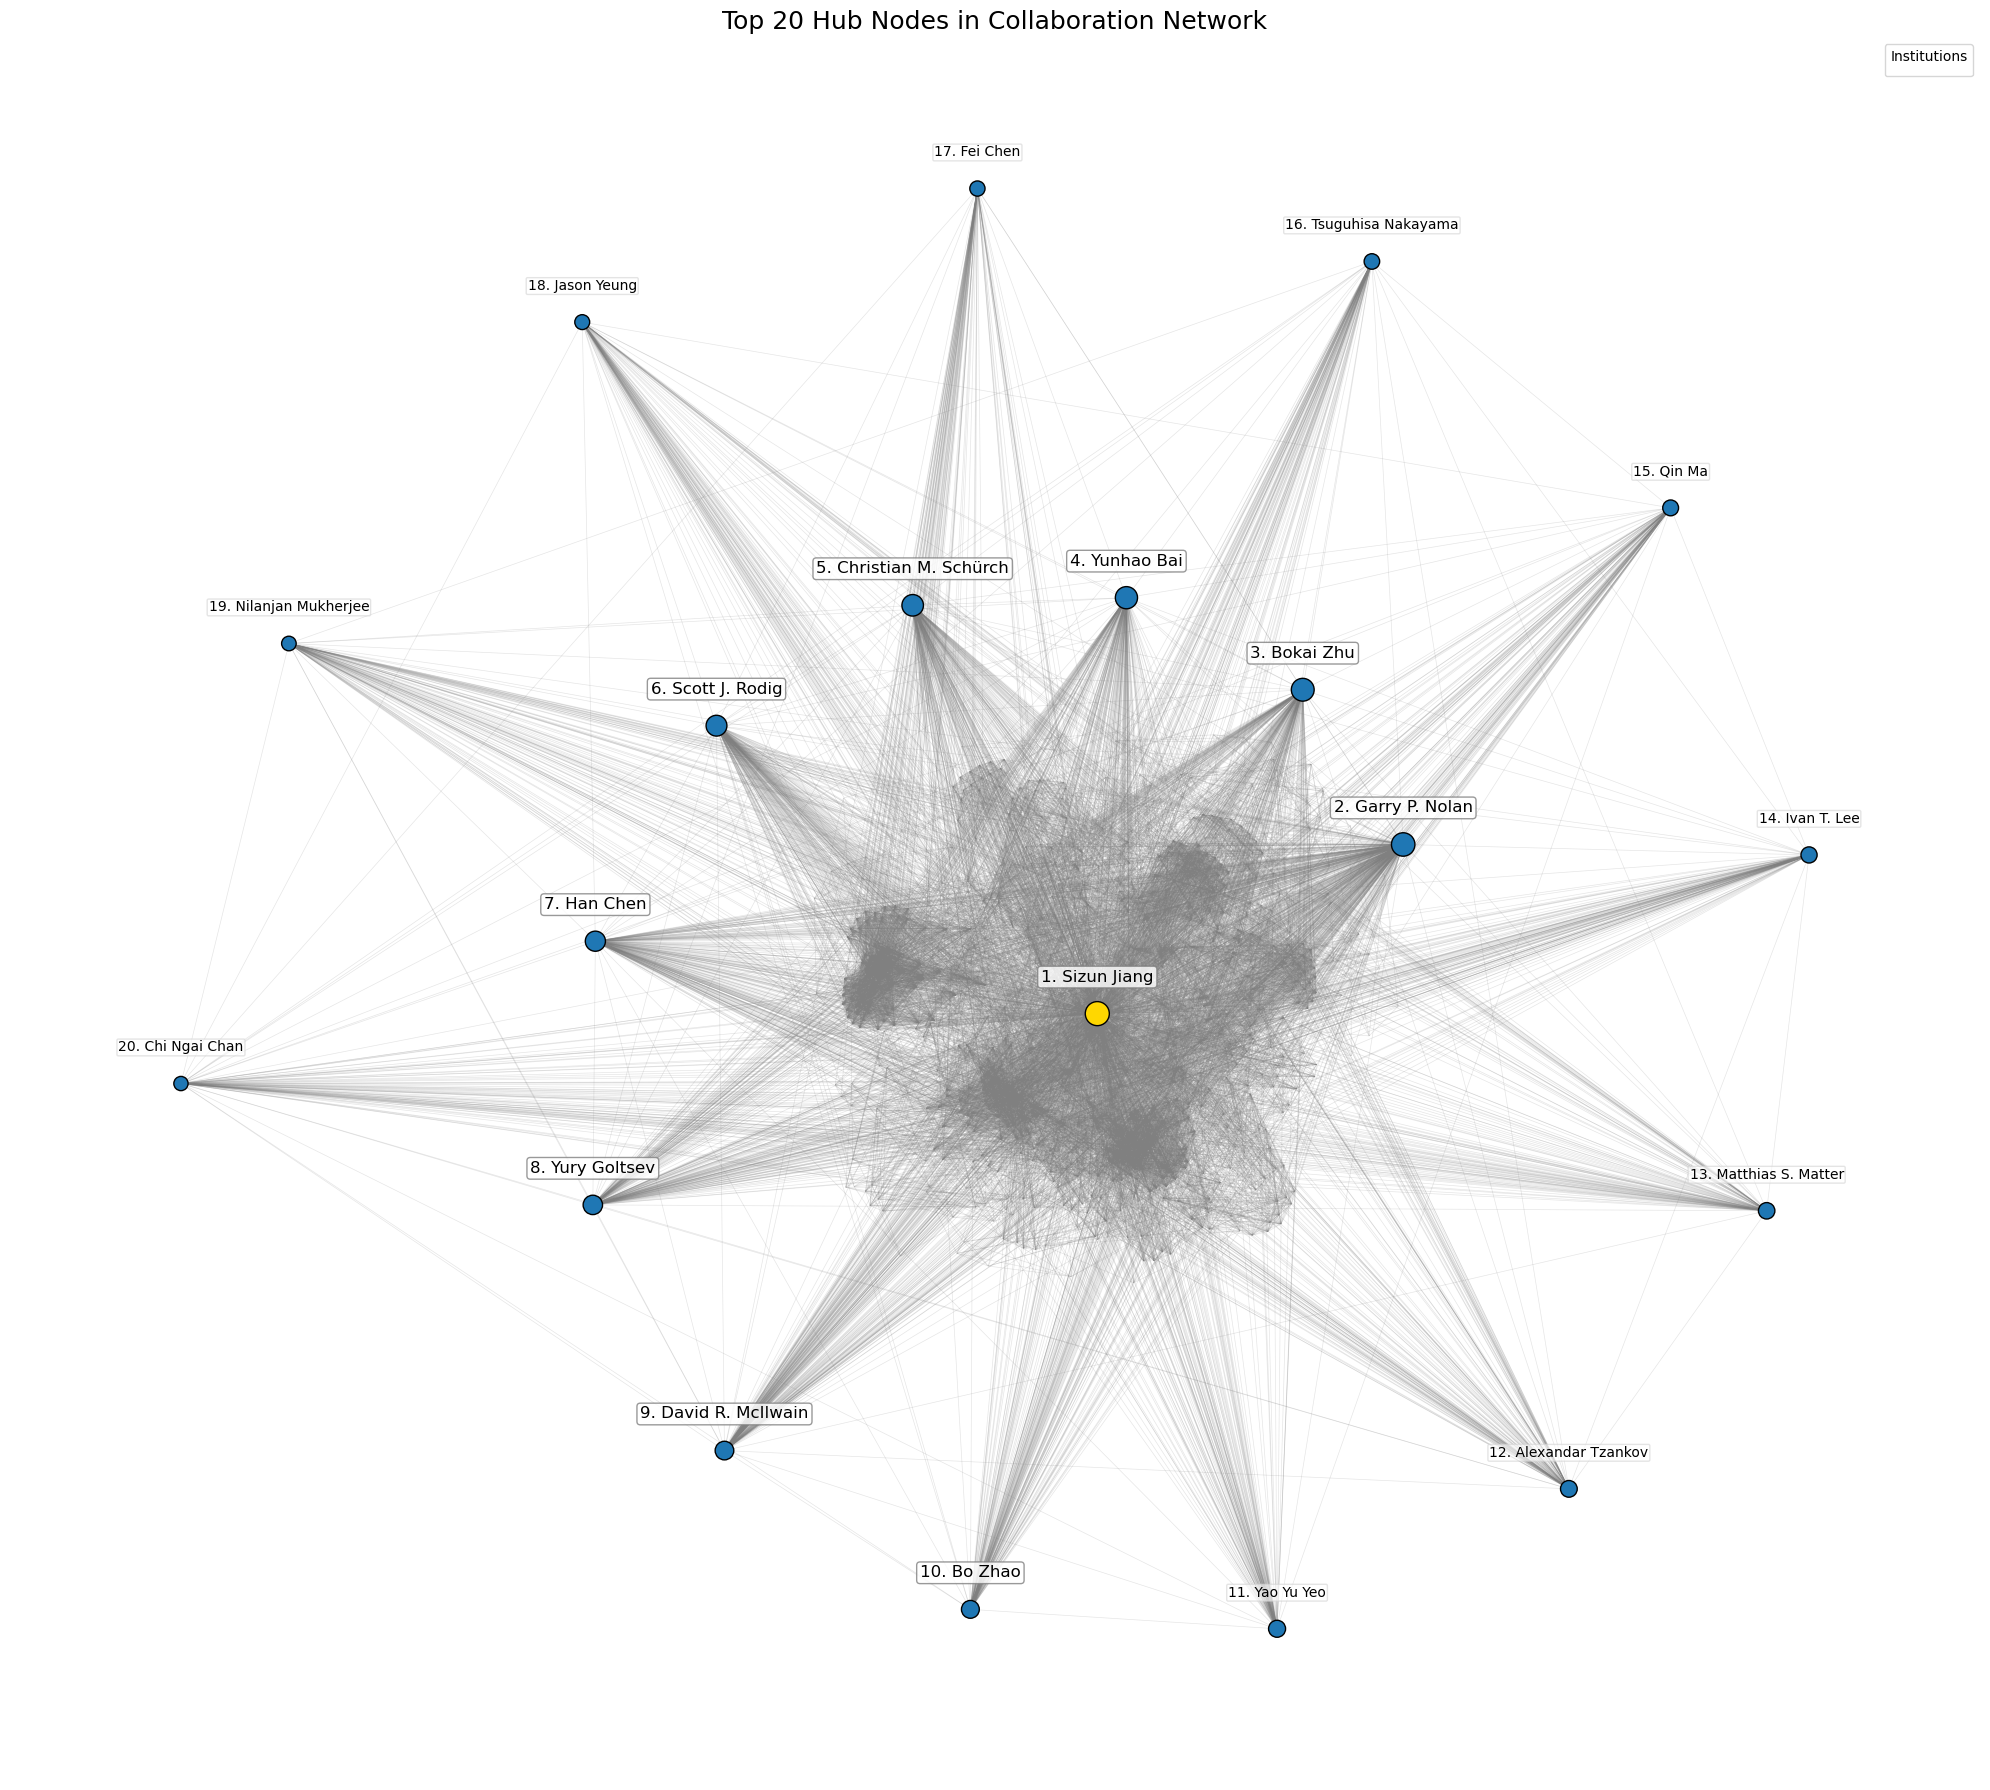

In [4]:
center_author = "Sizun Jiang"

# Calculate centrality metrics to identify hub nodes
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

# Calculate hub scores with balanced weighting
hub_score = {}
for node in G.nodes():
    hub_score[node] = (
        1 * degree_centrality[node] + 
        1 * betweenness_centrality[node] +
        1 * eigenvector_centrality[node]
    )

# Get top 20 hub nodes
num_hubs = 20
hub_nodes = sorted([(node, score) for node, score in hub_score.items()], 
                  key=lambda x: x[1], reverse=True)[:num_hubs]
hub_node_list = [h[0] for h in hub_nodes]

# Create initial layout
pos = nx.spring_layout(G, seed=42, k=0.5)

# Position hub nodes in a more natural spread
# Place center author in the middle if present
if center_author in hub_node_list:
    pos[center_author] = np.array([0, 0])
    
# Position remaining hub nodes in a more balanced way
# Use a spiral layout to avoid overcrowding
for i, node in enumerate(hub_node_list):
    if node != center_author:
        # Calculate spiral coordinates - provides more even spacing
        radius = 1.0 + (i * 0.1)
        angle = i * 0.5  # Less aggressive spiral
        pos[node] = np.array([radius * np.cos(angle), radius * np.sin(angle)])

# Create the figure
plt.figure(figsize=(20, 18))

# Draw all edges with uniform style
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray', width=0.5)

# Draw regular nodes with colors by institution
regular_nodes = [n for n in G.nodes() if n not in hub_node_list]
for inst, color_idx in institution_colors.items():
    nodes = [author for author in regular_nodes 
             if author_affiliation.get(author, ["Unknown"])[0] == inst]
    if nodes:
        color = plt.cm.tab10(color_idx)
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, 
                              node_color=[color], 
                              node_size=20, alpha=0.6, 
                              label=f"{inst}")

# Draw hub nodes with scaled sizes based on rank
# Top 10 get larger sizes than 11-20
hub_sizes = []
for i, (node, score) in enumerate(hub_nodes):
    if i < 10:  # Top 10
        size = 300 - (i * 15)
    else:  # 11-20
        size = 150 - ((i-10) * 5)
    hub_sizes.append(size)

# Color hub nodes by their institution
hub_colors = []
for node, _ in hub_nodes:
    if node == center_author:
        hub_colors.append('gold')
    else:
        inst = author_affiliation.get(node, ["Unknown"])[0]
        color_idx = institution_colors.get(inst, 0)
        hub_colors.append(plt.cm.tab10(color_idx))

# Draw hub nodes
nx.draw_networkx_nodes(G, pos, nodelist=hub_node_list, 
                      node_color=hub_colors, 
                      node_size=hub_sizes,
                      edgecolors='black', linewidths=1.0)

# Add labels for hub nodes with rank
for i, (node, score) in enumerate(hub_nodes):
    x, y = pos[node]
    rank = i+1
    if rank <= 10:  # Make top 10 labels more prominent
        fontsize = 12
        bbox = dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.2')
    else:
        fontsize = 10
        bbox = dict(facecolor='white', alpha=0.6, edgecolor='lightgray', boxstyle='round,pad=0.1')
        
    plt.text(x, y+0.1, f"{rank}. {node}", fontsize=fontsize, ha='center', 
             bbox=bbox)

# Create a custom legend for institution colors
plt.legend(scatterpoints=1, loc='upper right', fontsize=10, title="Institutions")

# Add title and remove axes
plt.title(f"Top 20 Hub Nodes in Collaboration Network", fontsize=18)
plt.axis('off')
plt.tight_layout()
